In [1]:
from astropy.table import Table, vstack, join 
from astropy.io import ascii
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np
import astropy.units as u
from scipy.stats import linregress, zscore
import sfdmap
np.int=int
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import json as json
import re

In [ ]:
import pandas as pd
from astropy.table import Table

df = pd.read_fwf("globby_params.txt", skiprows=0)  # or adjust to skip messy header
tbl = Table.from_pandas(df)
tbl['Name']=[name.strip().replace(" ","_") for name in tbl['ID']]

from astropy.table import Table
import numpy as np

from astropy.table import Table
import numpy as np

# Step 1: Read all lines and skip header/separator junk
with open("globby_dist.txt") as f:
    lines = f.readlines()

# Step 2: Filter data lines (skip empty and separator lines)
data_lines = [line for line in lines if line.strip() and not line.startswith(('ID', '__'))]

# Step 3: Define column names
colnames = ["ID", "Name", "RA", "DEC", "L", "B", "R_Sun", "R_gc", "X", "Y", "Z"]

# Step 4: Parse carefully by anchoring on last 9 columns
parsed_rows = []
for line in data_lines:
    parts = line.split()

    # Grab last 9 numerical fields (always at end)
    numeric_fields = parts[-9:]
    # Everything before that is ID and Name
    name_fields = parts[:-9]

    # Sometimes name spans multiple words—join all remaining parts
    if len(name_fields) >= 2:
        cluster_id = name_fields[0]
        name = " ".join(name_fields[1:])
    else:
        cluster_id = name_fields[0]
        name = ""

    row = [cluster_id, name] + numeric_fields
    parsed_rows.append(row)

# Step 5: Convert to Astropy Table
t = Table(rows=parsed_rows, names=colnames)
Dist=[float(dist)for dist in t['R_Sun'][1:]]
Dist=dict(zip(tbl['Name'],Dist))
dist_table = Table(rows=[(name, val) for name, val in Dist.items()], names=["Name", "R_Sun"])
print(dist_table)





    ID     v_r   +/-  v_LSR  sig_v +/-.1 ...  mu_V rho_0 lg(tc) lg(th)    Name  
--------- ------ ---- ------ ----- ----- ... ----- ----- ------ ------ ---------
  NGC 104  -18.0  0.1  -26.7  11.0   0.3 ... 14.38  4.88   7.84   9.55   NGC_104
  NGC 288  -45.4  0.2  -51.9   2.9   0.3 ... 20.05  1.78   8.99   9.32   NGC_288
  NGC 362  223.5  0.5  214.0   6.4   0.3 ...  14.8  4.74   7.76   8.93   NGC_362
Whiting 1 -130.6  1.8 -138.1    --    -- ...    --    --     --   7.93 Whiting_1
 NGC 1261   68.2  4.6   54.9    --    -- ... 17.73  2.99   8.59   9.12  NGC_1261
    Pal 1  -82.8  3.3  -76.2    --    -- ... 20.93  3.51   4.06   7.76     Pal_1
     AM 1  116.0 20.0  101.3    --    -- ... 23.62  0.03   8.96   9.61      AM_1
 Eridanus  -23.6  2.1  -39.1    --    -- ... 22.81  0.38   9.18   9.54  Eridanus
    Pal 2 -133.0 57.0 -140.1    --    -- ... 19.06  4.06   8.82   9.28     Pal_2
 NGC 1851  320.5  0.6  303.8  10.4   0.5 ... 14.25  5.09   7.43   8.82  NGC_1851
      ...    ...  ...    ...

In [25]:
def pmsd(filename):
    data=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+".txt", format="ascii")
    mask=data['memberprob']>0.97
    data=data[mask]
    sd_ra=np.std(data['pmra'])
    sd_dec=np.std(data['pmdec'])
    return sd_ra, sd_dec

In [5]:
def dusty(RA, DEC):
    m=sfdmap.SFDMap('C:\\Users\\rumki\\sfddata-master\\sfddata-master')
    return 2.740*m.ebv(RA, DEC)
    

In [6]:
def mag_cut(RA,DEC,R):
     g_mag=0.46+5*np.log10(R)-5+dusty(RA,DEC)
     return g_mag

In [5]:
def tidal(conc,core):
    tidal=core*10**conc
    return tidal

In [ ]:
tidal(0.55,0.25)

0.8870334730839388

In [29]:
def rr_dict():
    globby=Table.read("globby_parallax.fit", hdu=1)
    globby['ID']=[name.strip().replace(" ","_" )for name in globby['Name']]
    globby=join(globby, dist_table, keys_left="ID",keys_right="Name")
    globby_params=tbl
    globby_dict={}
    globby=join(globby,globby_params,keys_left='ID',keys_right="Name", join_type="inner")
    for recno in globby['recno']:
         mask=(globby['recno']==recno)
         name=globby[mask]['Name_1'][0]
         name=name.strip().replace(" ","_")
         if name not in ["E_1"]:
          globby_dict[name]=[]
          globby_dict[name].append(float(globby[mask]['pmRA'][0]))
          globby_dict[name].append(float(globby[mask]['pmDE'][0]))
          pm_sd=pmsd(name)
          globby_dict[name].append(round(float(pm_sd[0]),2))
          globby_dict[name].append(round(float(pm_sd[1]),2))
          globby_dict[name].append(float(globby[mask]['RAJ2000'][0]))
          globby_dict[name].append(float(globby[mask]['DEJ2000'][0]))
          globby_dict[name].append(float(globby[mask]['R_Sun'][0]))
          tidal_radius=round(float(tidal(float(globby[mask]['c'][0]),float(globby[mask]['r_c'][0]))),2)
          globby_dict[name].append(tidal_radius)
          globby_dict[name].insert(0, tidal_radius)

    return globby_dict

In [30]:
globby_dict=rr_dict()

C:\Users\rumki\AppData\Local\Temp\ipykernel_28340\3686127638.py:22: UserWarning: Warning: converting a masked element to nan.
  tidal_radius=round(float(tidal(float(globby[mask]['c'][0]),float(globby[mask]['r_c'][0]))),2)


In [2]:

with open("globby_dict.json", "r") as f:
    globby_dict=json.load(f)
del globby_dict['Pyxis']
del globby_dict['Eridanus']

In [3]:
globby_dict["AM_4"]

[2.05, -0.291, -2.512, 0.39, 0.66, 209.09, -27.167, 32.2, 2.05]

In [ ]:
def gaia_query():
 for name in list(globby_dict.keys())[129:]:
   params={"ra":globby_dict[name][5],
                "dec": globby_dict[name][6],
                "r":globby_dict[name][0]*0.1667,
                "mag_min":float(mag_cut(globby_dict[name][5],globby_dict[name][6],globby_dict[name][7]*1000))-0.5,
                "mag_max":float(mag_cut(globby_dict[name][5],globby_dict[name][6],globby_dict[name][7]*1000))+0.5}
   print(name)
   import logging
   logging.basicConfig()
   logging.getLogger('astroquery').setLevel(logging.DEBUG)

         
   query=f"""
         SELECT gaia_source.source_id,gaia_source.ra,gaia_source.dec,gaia_source.pmra,gaia_source.pmdec,
         gaia_source.pmra_error, gaia_source.pmdec_error, gaia_source.phot_g_mean_mag, gaia_source.bp_rp,
         vari_rrlyrae.pf,vari_rrlyrae.pf_error,vari_rrlyrae.best_classification
         FROM gaiadr3.gaia_source
         JOIN gaiadr3.vari_rrlyrae
         ON gaiadr3.gaia_source.source_id=gaiadr3.vari_rrlyrae.source_id
         WHERE 1= CONTAINS(
         POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
         CIRCLE('ICRS',{params['ra']},{params['dec']},{params['r']})
         )
         AND (gaiadr3.gaia_source.phot_g_mean_mag BETWEEN {params['mag_min']} AND {params['mag_max']})
         """

   job=Gaia.launch_job_async(query)
   result=job.get_results()
   result.write("C:\\Users\\rumki\\globby_rrs" +name+"_gaia_rr_10.csv",overwrite=True)


        
        

In [38]:
def glob_cut():
    globs=Table.read("asu.fit", hdu=1)
    mask1=(globs['Dist']>20) & (globs['Dist']<30)
    #mask2=(np.abs(globs['GLAT'])>30)
    globs=globs[mask1]
    globs.write("cleaned_globs.csv",overwrite=True)
    return globs

In [ ]:
def globby_px():
    glob_px=Table.read("globby_parallax.fit", hdu=1)
    globs=glob_cut()
    gnames = [str(name).strip() if not isinstance(name, bytes) else name.decode('utf-8').strip()
              for name in glob_px['Name']]
    target_names = ['NGC 2808']

    # Use np.isin on clean string arrays
    mask = np.isin(gnames, target_names)
    px=glob_px[mask]
    px.write("globby_px_cleaned.csv", overwrite=True)
    return px

In [4]:
def ps1(filename):
    glob=globby_dict[filename]
    ps1=ascii.read('ps1.csv')
    r=glob[0]*10/60*u.deg
    centre=SkyCoord(ra=glob[5]*u.deg, dec=glob[6]*u.deg)
    coords=SkyCoord(ra=ps1['RAdeg']*u.deg, dec=ps1['DEdeg']*u.deg)
    sep=centre.separation(coords)
    ps1['sep']=sep
    mask=ps1['sep']<r
    ps1_rr=ps1[mask]
    ps1_rr_cross=Table()
    ps1_rr_cross['ra']=ps1_rr['RAdeg']
    ps1_rr_cross['dec']=ps1_rr['DEdeg']
    ps1_rr_cross.write("ps1_rr_cross"+filename+".csv", format="ascii", overwrite=True)

In [3]:
def ztf(filename):
    glob=globby_dict[filename]
    ztf=Table.read('ZTF_rr.fit',hdu=1)
    r=glob[0]*10/60*u.deg
    centre=SkyCoord(ra=glob[5]*u.deg, dec=glob[6]*u.deg)
    coords=SkyCoord(ra=ztf['RAJ2000'], dec=ztf['DEJ2000'])
    sep=centre.separation(coords)
    ztf['sep']=sep
    mask=ztf['sep']<r
    ztf_rr=ztf[mask]
    ztf_rr_cross=Table()
    ztf_rr_cross['RA']=ztf_rr['RAJ2000']
    ztf_rr_cross['DEC']=ztf_rr['DEJ2000']
    ztf_rr_cross.write("ztf_rr_cross"+filename+".csv", format="csv", overwrite=True)
    

In [4]:
def cmd(filename, r,s):
    gal=globby_dict[filename]
    data=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+".txt", format="ascii")
    mask=data['memberprob']>0.80
    data=data[mask]
    rr=Table.read("C:\\Users\\rumki\\globby_rrs\\globby_rrs"+filename+"_gaia_rr_"+r+".csv", format="ascii.csv")
    #rr_ps1=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+"_ps1_rr_"+r+".csv", format="ascii.csv")
    #rr_ztf=Table.read("C:\\Users\\rumki\\globby_rrs\\"+"ZTF_"+filename+"_"+r+".csv", format="ascii.csv")

 
    

    
    #check=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+"_check.csv", format="ascii.csv")
    x, y = gal[1],gal[2]
    width=gal[3]
    height=gal[4]
    mask1=(rr['pmra']>x-width*3) & (rr['pmra']<x+width*3)
    mask2=(rr['pmdec']>y-height*3)& (rr['pmdec']<y+height*3)
    glob_coords=SkyCoord(ra=gal[5]*u.deg, dec=gal[6]*u.deg)
    cords=SkyCoord(ra=rr['ra']*u.deg,dec=rr['dec']*u.deg)
    rr['sep']=glob_coords.separation(cords)*60/u.deg*u.arcmin
    mask_sep=rr['sep']<gal[8]*s/60*u.deg 
    
    '''mask3=(rr_ps1['pmra']>x-width*3) & (rr_ps1['pmra']<x+width*3)
    mask4=(rr_ps1['pmdec']>y-height*3)& (rr_ps1['pmdec']<y+height*3)
    mask5=(rr_ztf['pmra']>x-width*3) & (rr_ztf['pmra']<x+width*3)
    mask6=(rr_ztf['pmdec']>y-height*3)& (rr_ztf['pmdec']<y+height*3)'''
    rr=rr[mask1&mask2&mask_sep]
    '''rr_ps1=rr_ps1[mask3&mask4]
    mask = ~np.isin(rr_ps1['source_id'], rr['source_id'])
    rr_ps1=rr_ps1[mask]
    rr_ztf=rr_ztf[mask5&mask6]
    mask=~np.isin(rr_ztf['source_id'], rr['source_id'])
    mask2=~np.isin(rr_ztf['source_id'], rr_ps1['source_id'])
    rr_ztf=rr_ztf[mask&mask2]'''


   # color=data["bp_rp"]
    #magnitude=data["g_mag"]-dusty(gal[5],gal[6])
    #rr_color=rr['bp_rp']
    #rr_mag=rr["phot_g_mean_mag"]-dusty(gal[5],gal[6])
    ''' rr_ps1_color=rr_ps1['bp_rp']
    rr_ps1_mag=rr_ps1["phot_g_mean_mag"]-dusty(gal[5],gal[6])
    rr_ztf_color=rr_ztf['bp_rp']
    rr_ztf_mag=rr_ztf["phot_g_mean_mag"]-dusty(gal[5],gal[6])'''


    '''plt.figure(figsize=(8,6))
    plt.scatter(color, magnitude, color="black")
    #plt.scatter(check['bp_rp'],check['phot_g_mean_mag'],marker='s',color='red',label='Reyes')
    plt.scatter(rr_color,rr_mag, color="green", marker="s",label="GAIA-DR3",alpha=1)
    #plt.scatter(rr_ps1_color,rr_ps1_mag,color="yellow",marker="^", label="PS-1")
    #plt.scatter(rr_ztf_color,rr_ztf_mag, color="red",label="ZTF")
    plt.xlabel("Color-index-(B-R)")
    plt.ylabel("G-mag")
    plt.title("CMD "+filename+"  R_gc="+r )
    plt.legend()
    plt.gca().invert_yaxis()
    plt.savefig("C:\\Users\\rumki\\globby_rrs\\cmds\\"+filename+".png")
    plt.show()
    plt.figure(figsize=(8,10))
    plt.scatter(data['ra'],data['dec'])
    plt.xlabel("RA")
    plt.ylabel("DEC")
    plt.title(filename)'''
    return rr

In [7]:
cmd("NGC_2419","10",1)

source_id,ra,dec,pmra,pmdec,pmra_error,pmdec_error,phot_g_mean_mag,bp_rp,pf,pf_error,best_classification,sep
,,,,,,,,,,,,arcmin
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64
899279397741381888,114.58838893080531,38.83977264526304,0.45887582812178296,0.23395659083167608,0.7059282660484314,0.4000728726387024,20.285551071166992,0.5912723541259766,--,--,RRc,3.5554329165331477
899282004785415040,114.54455213574619,38.84748748192817,-0.13068609711856388,-0.42156706650212794,0.7067511677742004,0.42842406034469604,20.207027435302734,0.36414337158203125,--,--,RRc,2.118290124398142
899282382740840960,114.55359576786624,38.845483854506796,-0.6174439015527182,-0.7199195358238066,0.6912750601768494,0.37836959958076477,20.252456665039062,0.7890872955322266,--,--,RRc,2.3569252067958364
899282520183903232,114.57355186569544,38.878948813939246,0.3625794036793719,-1.1335629025210348,0.9907898306846619,0.828994631767273,20.24643325805664,0.5893020629882812,0.5766784020748893,1.5456666005775332e-05,RRab,1.809940816857137
899282524477570176,114.57053006748095,38.87779282400362,0.058521171179537645,-0.7397458510064874,0.8140047788619995,0.5140337944030762,20.264314651489258,0.551666259765625,0.6403224049999844,2.5329034542664886e-05,RRab,1.6786202569948474
899282627553641344,114.5547323758903,38.868887001310114,-0.2671928892495822,-0.6744620619750119,0.7417303919792175,0.4395672678947449,20.26681137084961,0.5877094268798828,--,--,RRc,1.2118493521920584
899282627553726720,114.55044373877183,38.86638106208404,1.7522395834889228,-0.010625398834600612,0.6487987637519836,0.37054458260536194,20.192934036254883,0.7666873931884766,--,--,RRc,1.1826427610253805
899282627554780416,114.55742207364929,38.879910395667906,-0.8385970386501836,-2.225647945132167,0.860877275466919,0.6313439607620239,20.355430603027344,0.3883171081542969,--,--,RRc,1.0547484104053517


In [ ]:
rr_all=[]

def enforce_str_dtype(tbl, colname='best_classification'):
    if colname in tbl.colnames:
        # Convert column to string type if not already
        tbl[colname] = np.array(tbl[colname], dtype='U32')  # or 'U128' if needed
    return tbl
for name in globby_dict:
    result=cmd(name,"10")
    result=enforce_str_dtype(result)
    rr_all.append(result)


In [ ]:
def pm(filename,r):
    gal=glob_radius_and_pmdict[filename]
    data=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+".txt", format="ascii")
    #field=Table.read("field_px.csv")
    mask=data['memberprob']>0.75
    data=data[mask]
    rr=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+"_rr_gaia_"+r+".csv", format="ascii.csv")
    rr_ps1=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+"_ps1_rr_"+r+".csv", format="ascii.csv")
    mask = ~np.isin(rr_ps1['source_id'], rr['source_id'])
    rr_ps1=rr_ps1[mask]
    rr_ztf=Table.read("C:\\Users\\rumki\\globby_rrs\\"+"ZTF_"+filename+"_"+r+".csv", format="ascii.csv")
    mask=~np.isin(rr_ztf['source_id'], rr['source_id'])
    mask2=~np.isin(rr_ztf['source_id'], rr_ps1['source_id'])
    rr_ztf=rr_ztf[mask&mask2]

    x, y = gal[1],gal[2]
    width=gal[3]
    height=gal[4]
    rect=patches.Rectangle((x-width*3,y-height*3), width*6, height*6, linewidth=2, alpha=0.5)
    pmra=rr['pmra']
    pmdec=rr["pmdec"]
    pmra_ps1=rr_ps1['pmra']
    pmdec_ps1=rr_ps1["pmdec"]
    pmra_ztf=rr_ztf['pmra']
    pmdec_ztf=rr_ztf["pmdec"]
    plt.figure(figsize=(8,6))
    ax=plt.subplot()
    #plt.errorbar(field['pmra'],field['pmdec'],xerr=field['pmra_error'], yerr=field['pmdec_error'],
                 #color="black",label="field",fmt="o",alpha=0.1)
    plt.errorbar(pmra,pmdec,xerr=rr['pmra_error'], yerr=rr['pmdec_error'], label="GAIA", fmt="o")
    plt.errorbar(pmra_ps1,pmdec_ps1,xerr=rr_ps1['pmra_error'], yerr=rr_ps1['pmdec_error'], label="PS-1", fmt="o", color="yellow")
    plt.errorbar(pmra_ztf,pmdec_ztf,xerr=rr_ztf['pmra_error'], yerr=rr_ztf['pmdec_error'], label="ZTF", fmt="o", color="red")
    plt.scatter(data['pmra'],data['pmdec'], s=100, color='orange', marker='s',label="cluster")
    #plt.errorbar(check['pmra'],check['pmdec'],xerr=check['pmra_error'], yerr=check['pmdec_error'],color="green",
     #            label="Reyes", fmt="o")
    ax.add_patch(rect)
    plt.xlabel('pmra')
    plt.ylabel('pmdec')
    plt.legend()
    plt.title(filename+" "+r+"R_gc")
    plt.show()

In [5]:
with open("rr_count_dict.json","r") as f:
    rr_count_dict=json.load(f)
    

In [23]:
def profile(filename, radius):
 df = pd.read_fwf("globby_params.txt", skiprows=0)  # or adjust to skip messy header
 tbl = Table.from_pandas(df)
 tbl['Name']=[name.strip().replace(" ","_") for name in tbl['ID']]

 
 gal=globby_dict[filename]
 data=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+".txt", format="ascii")
 mask=data['memberprob']>0.80
 data=data[mask]
 rr=Table.read("C:\\Users\\rumki\\globby_rrs\\globby_rrs"+filename+"_gaia_rr_"+radius+".csv", format="ascii.csv")
 #rr_ps1=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+"_ps1_rr_"+r+".csv", format="ascii.csv")
 #rr_ztf=Table.read("C:\\Users\\rumki\\globby_rrs\\"+"ZTF_"+filename+"_"+r+".csv", format="ascii.csv")

 
    

    
    #check=Table.read("C:\\Users\\rumki\\globby_rrs\\"+filename+"_check.csv", format="ascii.csv")
 x, y = gal[1],gal[2]
 width=gal[3]
 height=gal[4]
 mask1=(rr['pmra']>x-width*3) & (rr['pmra']<x+width*3)
 mask2=(rr['pmdec']>y-height*3)& (rr['pmdec']<y+height*3)
 glob_coords=SkyCoord(ra=gal[5]*u.deg, dec=gal[6]*u.deg)
 cords=SkyCoord(ra=rr['ra']*u.deg,dec=rr['dec']*u.deg)
 rr['sep']=glob_coords.separation(cords)
 mask_sep=rr['sep']<gal[8]/60*u.deg
    
 '''mask3=(rr_ps1['pmra']>x-width*3) & (rr_ps1['pmra']<x+width*3)
 mask4=(rr_ps1['pmdec']>y-height*3)& (rr_ps1['pmdec']<y+height*3)
 mask5=(rr_ztf['pmra']>x-width*3) & (rr_ztf['pmra']<x+width*3)
 mask6=(rr_ztf['pmdec']>y-height*3)& (rr_ztf['pmdec']<y+height*3)'''
 rr=rr[mask1&mask2&mask_sep]
 sep_sorted=np.sort(rr['sep'])
 bins=np.array([n/1000*gal[8]/60 for n in range(1,1001)])
 bins=bins*u.deg
 sep_binned, bin_edges=np.histogram(sep_sorted,bins)
 bins=bins/u.deg*3.14/180*gal[7]*1000
 count_per_area=np.array([sep_binned[i]/(3.14*bins[i+1]**2-3.14*bins[i]**2) for i in range(0,999)])
 bin_edges=bin_edges*3.14/180*gal[7]*1000
 max_count=max(count_per_area)
 min_index=np.argmax(count_per_area>0)
 min_radius=bin_edges[min_index]

 from astropy.modeling.models import KingProjectedAnalytic1D
 r_t=globby_dict[filename][0]/60*3.14/180*1000*globby_dict[filename][7]
 masked_tbl=tbl[tbl['Name']==filename]
 r_c=masked_tbl["r_c"][0]/60*3.14/180*1000*globby_dict[filename][7]
 amp = 1
 king_model=KingProjectedAnalytic1D(amplitude=amp, r_core=r_c, r_tide=r_t)
 r=np.linspace(min_radius,r_t,200)
 sigma=king_model(r)
 plt.figure(figsize=(6,4))
 plt.plot(r, sigma/sigma[0], label=f"c ≈ {king_model.concentration:.2f}")
 plt.xlabel("Radius (r) [pc]")
 plt.ylabel(r"$\Sigma(r)/\Sigma_0$")
 plt.title("Number Surface Density Profile "+filename)
 plt.legend()
 plt.plot(bin_edges[1:],count_per_area/max_count)
 plt.ylabel(r"$\Sigma(r)/\Sigma_0$")
 plt.savefig("C:\\Users\\rumki\\globby_rrs\\profile\\"+filename+"_king_overlaid.png")

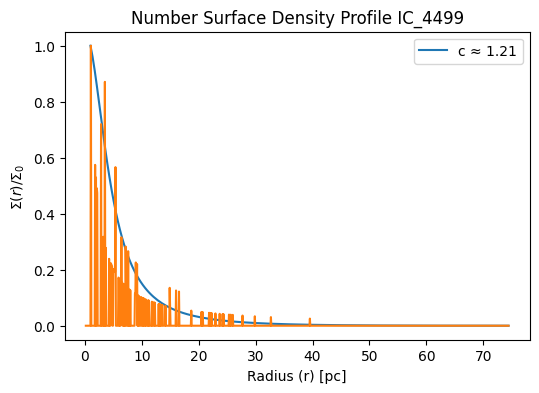

In [35]:
profile("IC_4499","10")

In [111]:
min_edge[-6]

np.float64(0.5048552000000001)

In [ ]:
def distplot(filename,r):
    glob=globby_dict[filename]
    rrs=cmd(filename,r)
    plt.ion()
    tidal=glob[8]
    rr=rrs
    glob_coords=SkyCoord(ra=glob[5]*u.deg, dec=glob[6]*u.deg)
    cords=SkyCoord(ra=rr['ra']*u.deg,dec=rr['dec']*u.deg)
    rr['sep']=glob_coords.separation(cords)*60/u.deg*u.arcmin
    mask=rr['sep']<glob[8]*1/60*u.deg 
    rr=rr[mask]
    return(len(rr))
    if len(rr)>5:
     sep_sorted=np.sort(rr['sep'].value)
     cmf=np.arange(1,len(sep_sorted)+1)
     radii=np.linspace(0,tidal*10,11)
     number=[str(float(n)) for n in range(0,11,1)]
     growth=np.gradient(cmf,sep_sorted)
     #plt.hist(sep_sorted, bins=radii)
   
    ''' plt.figure(figsize=(8,10))
     ax=plt.subplot()
     plt.step(sep_sorted,cmf)
     plt.grid(True)
     ax.set_xticks(radii, labels=number)
     plt.title("CMF "+ filename)
     plt.xlabel("R/R_tidal")
     plt.ylabel("# RR Lyrae")
     plt.legend()
     plt.savefig("C:\\Users\\rumki\\globby_rrs\\CFDs_10R_t\\"+filename+"_CMF.png")
     #plt.show()'''

    '''plt.figure(figsize=(8,10))
     ax=plt.subplot()
     plt.hist(sep_sorted,bins=radii,edgecolor="black")
     ax.set_xticks(radii, labels=number)
     plt.xlabel("R by R_tidal")
     plt.ylabel("# stars")
     plt.title("Tidal Histogram "+filename)
     plt.savefig("C:\\Users\\rumki\\globby_rrs\\Histogram\\"+filename+"_hist.png")
     plt.show()
    
     plt.figure(figsize=(8,10))
     ax=plt.subplot()
     plt.plot(sep_sorted,growth)
     ax.set_xticks(radii, labels=number)
     plt.title("Growth "+filename)
     plt.xlabel("R/R_tidal")
     plt.ylabel("# RR Lyrae/R")
     plt.savefig("C:\\Users\\rumki\\globby_rrs\\growth\\"+filename+"_growth.png")
     plt.show()'''





In [4]:
def comp(name):
    gal=globby_dict[name]
    data=Table.read("C:\\Users\\rumki\\globby_rrs\\"+name+".txt", format="ascii")
    mask=data['memberprob']>0.80
    data=data[mask]
    reyes=Table.read(r"C:\Users\rumki\globby_rrs\reyes_rr.fit",hdu=1)
    ours=Table.read(r"C:\Users\rumki\all_rr_table.csv")
    gnames = [str(name).strip() if not isinstance(name, bytes) else name.decode('utf-8').strip()
              for name in reyes['Cluster']]
    target_names = [name]

    # Use np.isin on clean string arrays
    mask1 = np.isin(gnames, target_names)
    mask2=(reyes['likelihood']>=0.8)
    
    reyes=reyes[mask1&mask2]
    glob_coords=SkyCoord(ra=gal[5]*u.deg, dec=gal[6]*u.deg)
    cords=SkyCoord(ra=reyes['_RA'],dec=reyes['_DE'])
    reyes['sep']=glob_coords.separation(cords)*60/u.deg*u.arcmin
    cords=SkyCoord(ra=reyes['_RA'],dec=reyes['_DE'])
    reyes['sep']=glob_coords.separation(cords)*60/u.deg*u.arcmin
    mask_sep=reyes['sep']<gal[8]*10/60*u.deg
    reyes=reyes[mask_sep]
    ours=ours[ours['Name']==name]
    cords=SkyCoord(ra=ours['ra']*u.deg,dec=ours['dec']*u.deg)
    ours['sep']=glob_coords.separation(cords)*60/u.deg*u.arcmin
    mask_sep=ours['sep']<gal[8]*1/60*u.deg
    ours=ours[mask_sep]

    count_diff=len(ours)-len(reyes)
    plt.figure(figsize=(8,10))
    plt.scatter(data['ra'],data['dec'], color='black',label='cluster')
    plt.scatter(ours['ra'],ours['dec'],color='red',label="Our Method",alpha=0.5)
    plt.scatter(reyes['_RA'],reyes['_DE'],color='green',label="Reyes 2024")
    plt.xlabel("RA [deg]")
    plt.ylabel("DE [deg]")
    plt.legend()
    plt.show()
    return count_diff

In [ ]:
def rr_count_Blat():
    count=[rr_count_dict[name][0] for name in rr_count_dict]
    blat=[rr_count_dict[name][4] for name in rr_count_dict]
    dist=[rr_count_dict[name][1] for name in rr_count_dict]
    plt.figure(figsize=(8,10))
    sc=plt.scatter(blat,count, c=dist,cmap='viridis')
    plt.xlabel("BLAT [deg]")
    plt.ylabel("Number of RR Lyrae")
    plt.colorbar(sc,label="Distance[kpc]")
    plt.title("Count vs. BLAT")
    plt.show()

In [23]:
def rr_count_tidal():
    count=[rr_count_dict[name][0] for name in rr_count_dict]
    tidal=[(globby_dict[name][-1]*1000*rr_count_dict[name][1]*3.14/10800) for name in rr_count_dict]
    plt.figure(figsize=(8,10))
    plt.scatter(tidal,count)
    plt.xlabel("Tidal radius [pc]")
    plt.ylabel("Number of RR Lyrae")
    plt.title("Count vs. Tidal Radius")
    plt.show()